# Treasure Hunt Game

In [125]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

In [126]:
# 8x8 maze object
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [127]:
# visualizes the maze
def show(qmaze):
    # show grid lines
    plt.grid('on')
    
    # rows and columns of maze
    nrows, ncols = qmaze.maze.shape
    
    # get current axes
    ax = plt.gca()
    
    # add ticks for visual flair
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # return array copy of maze
    canvas = np.copy(qmaze.maze)
    
    # 
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
        
    # current location of pirate cell
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell shading
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell shading
    
    # plot and show 
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [128]:
# four potential movements for the pirate cell
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# exploration factor
epsilon = 0.1

# actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


In [130]:
# simulates a full game, needs the trained model
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

In [131]:
# check of unsolvable mazes
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [132]:
# define network
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

In [133]:
# deep q learning
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    #each iteration will evaluate an agent attempting the too solve the maze
    for epoch in range(n_epoch):
        #variables for tracking progress the agent makes in the game
        loss = 0.0
        game_over = False
        n_episodes = 0
        
        #randomly select a free cell
        #stating location
        agent_cell = random.choice(qmaze.free_cells)
        
        #set agent at starting position
        qmaze.reset(agent_cell)
        
        #gets current state
        envstate = qmaze.observe()
        
        #keep looping until the agent gets to the target location or
        #if the reward goes below the minimum reward:
        while not game_over:
            #get possible move locations
            valid_actions = qmaze.valid_actions()
            
            #invalid starting location, end game 
            if not valid_actions:
                break

            #get previous envstate
            prev_envstate = envstate 
            
            #mutation, 10% of the time the agent will randomly explore instead of "thinking ahead"
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions) #Actions = randomly chosen action
            else:
                #grabs the first prediction after Sequential.predict() analysis the environment state
                action = np.argmax(experience.predict(prev_envstate))
                
                
            #apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over=True
            elif game_status == 'lose':
                win_history.append(0)
                game_over=True
            else:
                game_over=False
        
            #store episode in Experience Replay Object
            episode = [prev_envstate, action, reward, envstate, game_status]
            n_episodes += 1
            
            #stores 100 recent episodes, for learning
            experience.remember(episode)
            
            #train neural network model and evaluate loss
            inputs, targets = experience.get_data(data_size=data_size)
            History = model.fit(
                inputs, 
                targets, 
                epochs=20,
                batch_size=50,
                verbose=0
            ) 
            loss = model.evaluate(inputs, targets, verbose=0)
            
        #if winrate is above threshold and model passes completion check
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
        

        ###information aspect of the AI###
        #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05 #5% exploration chance
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    #determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

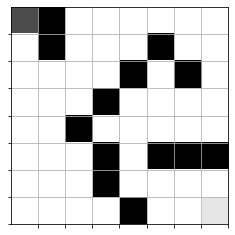

In [134]:
# set up teting environment for model
qmaze = TreasureMaze(maze)
show(qmaze)

In [135]:
# build model and train network
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch: 000/14999 | Loss: 0.0009 | Episodes: 86 | Win count: 1 | Win rate: 0.000 | time: 184.5 seconds
Epoch: 001/14999 | Loss: 0.0010 | Episodes: 122 | Win count: 2 | Win rate: 0.000 | time: 8.33 minutes
Epoch: 002/14999 | Loss: 0.0009 | Episodes: 156 | Win count: 2 | Win rate: 0.000 | time: 14.97 minutes
Epoch: 003/14999 | Loss: 0.0007 | Episodes: 3 | Win count: 3 | Win rate: 0.000 | time: 15.10 minutes
Epoch: 004/14999 | Loss: 0.0011 | Episodes: 44 | Win count: 4 | Win rate: 0.000 | time: 16.97 minutes
Epoch: 005/14999 | Loss: 0.0008 | Episodes: 36 | Win count: 5 | Win rate: 0.000 | time: 18.54 minutes
Epoch: 006/14999 | Loss: 0.0007 | Episodes: 9 | Win count: 6 | Win rate: 0.000 | time: 18.93 minutes
Epoch: 007/14999 | Loss: 0.0010 | Episodes: 10 | Win count: 7 | Win rate: 0.000 | time: 19.38 minutes
Epoch: 008/14999 | Loss: 0.0005 | Episodes: 51 | Win count: 8 | Win rate: 0.000 | time: 21.62 minutes
Epoch: 009/14999 | Loss: 0.0014 | Episodes: 30 | Win count: 9 | Win rate: 0.000 | t

8566.279499

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

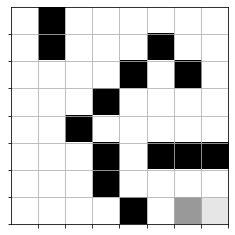

In [136]:
# check if modelpasses the completion check
completion_check(model, qmaze)
show(qmaze)

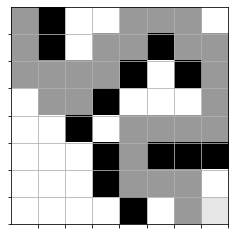

In [140]:
# test model
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)